In [1]:
import numpy as np
import math

from scipy.linalg import solve_triangular as scipy_solve_triangular
from scipy.linalg import qr as sp_qr
from scipy.linalg import solve_triangular as sp_solve_triangular
from scipy.sparse.linalg import SuperLU as sp_SuperLU
from scipy.sparse.linalg import cg as sp_cg
import scipy.sparse as sps

from scipy.stats import linregress

import jlinops


from jlinops import MatrixLinearOperator, _CustomLinearOperator 
from jlinops import banded_cholesky
from jlinops import DiagonalOperator
from jlinops import Dirichlet2DSym # Neumann2D
from jlinops import dct_sqrt_pinv, dct_pinv
from jlinops import cg
from jlinops import issparse, tosparse, get_device
from jlinops import QRPinvOperator


from jlinops import CUPY_INSTALLED
if CUPY_INSTALLED:
    import cupy as cp
    from cupyx.scipy.linalg import solve_triangular as cp_solve_triangular
    from cupy.linalg import qr as cp_qr
    from cupyx.scipy.sparse.linalg import SuperLU as cp_SuperLU



import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
mpl.rc('text.latex', preamble=r'\usepackage{amsmath}')



# Uniform theta

## Iteration experiment

### Preconditioned

In [2]:
#Ns = [10, 25, 50, 100, 250, 500]
Ns = [10, 25, 50, 100, 250, 500, 700]
#Ns = [5, 25, 50, 100]
# Ns = np.asarray([500])
n_samples = 100
#n_samples = 10
preconditioned_mean_cg_its = []
tol = 1e-5

np.random.seed(0)

# Iterate over N
for N in Ns:

    it_counts = []
    for j in range(n_samples):

        _R = Dirichlet2DSym((N,N))
        w = np.random.uniform(low=1, high=5, size=_R.shape[0])
        Apinv = jlinops.CGWeightedDirichlet2DSymPinvOperator((N,N), 1.0/np.sqrt(w) , tol=tol)
        R = DiagonalOperator(1.0/np.sqrt(w)) @ _R 
        
        # Initialize a counter for the iterations
        iteration_count = 0

        # Define the callback function
        def callback(xk):
            global iteration_count
            iteration_count += 1

        v = np.random.normal(size=R.shape[1])
        _ = sp_cg(Apinv.inv_lap.C, Apinv.inv_lap.Loblique.T @ v, callback=callback, M=None, tol=tol)

        it_counts.append(iteration_count)
        #print(iteration_count)

    mean_its = np.mean(it_counts)
    preconditioned_mean_cg_its.append(mean_its)

In [3]:
preconditioned_mean_cg_its

[12.58, 17.31, 24.52, 30.86, 45.73, 60.67, 70.76]

### Not preconditioned

In [4]:
#Ns = [10, 25, 50, 100, 250, 500]
#Ns = np.asarray([10, 25, 50, 100, 250, 500])
# Ns =  [50]
# Ns = [5, 25, 50, 100]
# Ns = [500]
Ns = [10, 25, 50, 100, 250, 500, 700]
n_samples = 100
mean_cg_its = []
tol = 1e-5

np.random.seed(0)

# Iterate over N
for N in Ns:

    it_counts = []
    for j in range(n_samples):

        _R = Dirichlet2DSym((N,N))
        w = np.random.uniform(low=1, high=5, size=_R.shape[0])
        Apinv = jlinops.CGWeightedDirichlet2DSymPinvOperator((N,N), 1.0/np.sqrt(w) , tol=tol)
        R = DiagonalOperator(1.0/np.sqrt(w)) @ _R 
        
        # Initialize a counter for the iterations
        iteration_count = 0

        # Define the callback function
        def callback(xk):
            global iteration_count
            iteration_count += 1

        v = np.random.normal(size=R.shape[0])
        _ = sp_cg(R.T @ R, R.T @ v, callback=callback, tol=tol)

        it_counts.append(iteration_count)
        #print(iteration_count)

    mean_its = np.mean(it_counts)
    mean_cg_its.append(mean_its)

In [5]:
mean_cg_its

[30.68, 68.96, 127.12, 236.19, 512.04, 914.95, 1151.12]

### Plotting

In [6]:
Ns = np.asarray(Ns)

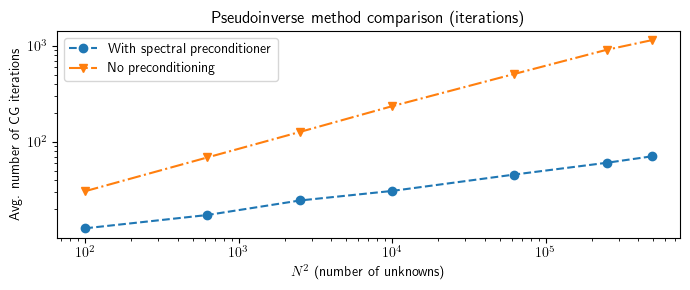

In [7]:
plt.figure(figsize=(7,3))
plt.loglog(Ns**2, preconditioned_mean_cg_its, label="With spectral preconditioner", ls="dashed", marker="o")
plt.loglog(Ns**2, mean_cg_its, label="No preconditioning", ls="dashdot", marker="v")
plt.ylabel("Avg. number of CG iterations")
plt.xlabel("$N^2$ (number of unknowns)")
plt.title("Pseudoinverse method comparison (iterations)")
plt.legend()
plt.tight_layout()
plt.show()

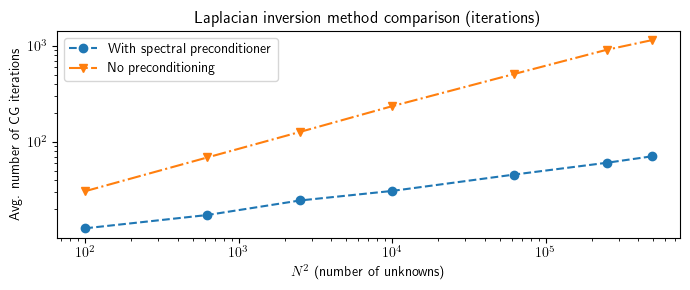

In [8]:
plt.figure(figsize=(7,3))
plt.loglog(Ns**2, preconditioned_mean_cg_its, label="With spectral preconditioner", ls="dashed", marker="o")
plt.loglog(Ns**2, mean_cg_its, label="No preconditioning", ls="dashdot", marker="v")
plt.ylabel("Avg. number of CG iterations")
plt.xlabel("$N^2$ (number of unknowns)")
plt.title("Laplacian inversion method comparison (iterations)")
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
linregress(np.log(Ns**2), np.log(preconditioned_mean_cg_its))

LinregressResult(slope=0.20402186027324473, intercept=1.572785601951258, rvalue=0.999348646249577, pvalue=2.0789525446250514e-08, stderr=0.0032947874117128443, intercept_stderr=0.031914921355818755)

In [10]:
linregress(np.log(Ns**2), np.log(mean_cg_its))

LinregressResult(slope=0.4292585209004831, intercept=1.474345050932147, rvalue=0.9997532407305455, pvalue=1.8368771711257525e-09, stderr=0.004265461678728334, intercept_stderr=0.04131734676990988)

## Timing experiment

In [11]:
import timeit

### With preconditioning

In [15]:
#Ns = [10, 25, 50, 100, 250, 500]
#Ns = [10, 25, 50, 100, 250, 500]
Ns = [10, 25, 50, 100, 250, 500, 700]
n_samples = 100
tol = 1e-5

np.random.seed(0)

preconditioned_time_costs = []


# Iterate over N
for N in Ns:


    setup_code = f'''import numpy as np \nfrom scipy.sparse.linalg import cg as sp_cg \nimport jlinops \nN = {N} \ntol={tol} \n_R = jlinops.Dirichlet2DSym((N,N)) \nw = np.random.uniform(low=1, high=5, size=_R.shape[0]) \nApinv = jlinops.CGWeightedDirichlet2DSymPinvOperator((N,N), 1.0/np.sqrt(w) , tol=tol)\nv = np.random.normal(size=_R.shape[1])'''

    test_code = f'''_ = sp_cg(Apinv.inv_lap.C, Apinv.inv_lap.Loblique.T @ v, M=None, tol={tol})'''

    
    time_cost = timeit.timeit(stmt=test_code, setup=setup_code, number=n_samples)
    time_per = time_cost/n_samples
    preconditioned_time_costs.append(time_per)
    

In [16]:
preconditioned_time_costs

[0.015558784989989362,
 0.027265955769980792,
 0.037703086599940434,
 0.17171296839020214,
 0.5857383918200503,
 2.6978039389502375,
 4.632059438569995]

### No preconditioning

In [17]:
#Ns = [10, 25, 50, 100, 250, 500]
#Ns = [10, 25, 50, 100, 250, 500]
Ns = [10, 25, 50, 100, 250, 500, 700]
n_samples = 100
tol = 1e-5

np.random.seed(0)

time_costs = []


# Iterate over N
for N in Ns:


    setup_code = f'''import numpy as np \nfrom scipy.sparse.linalg import cg as sp_cg \nimport jlinops \nN = {N} \ntol={tol} \n_R = jlinops.Dirichlet2DSym((N,N)) \nw = np.random.uniform(low=1, high=5, size=_R.shape[0]) \nR = jlinops.DiagonalOperator(1.0/np.sqrt(w)) @ _R  \nv = np.random.normal(size=_R.shape[0])'''

    test_code = f'''_ = sp_cg(R.T @ R,  R.T @ v, M=None, tol={tol})'''

    
    time_cost = timeit.timeit(stmt=test_code, setup=setup_code, number=n_samples)
    time_per = time_cost/n_samples
    time_costs.append(time_per)
    

In [18]:
time_costs

[0.003511334880022332,
 0.008052022760093678,
 0.015205620810156688,
 0.048668669920007235,
 0.6575335137397633,
 6.771669900009874,
 28.960432292500045]

#### Also do banded cholesky?

In [19]:
N = 300

delta = 0.0
Rmat = jlinops.build_dirichlet2dsym_sparse_matrix( (N,N) )
w = np.random.uniform(low=1, high=5, size=Rmat.shape[0])
Dw = sps.diags(w)
Rtilde = sps.diags(1.0/np.sqrt(w)) @ Rmat
Rtilde = jlinops.MatrixLinearOperator(Rtilde)
Rtilde_pinv = jlinops.BandedCholeskyPinvOperator(Rtilde, delta=delta)

# w = np.random.uniform(low=1, high=5, size=2*N*N)
# Apinv = jlinops.CGWeightedNeumann2DPinvOperator((N,N), 1.0/np.sqrt(w) , tol=tol)
# v = np.random.normal(size=2*N*N)
# _ = sp_cg(Apinv.Rwpinv.C, Apinv.Rwpinv.A.T @ v, callback=callback, tol=tol)

/Users/jonathanlindbloom/opt/miniconda3/envs/jlinops/lib/python3.11/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [20]:
#Ns = [10, 25, 50, 100, 250, 500]
#Ns = [10, 25, 50, 100, 250, 500]
#Ns = np.asarray([10, 25, 50, 100, 250, 500])
chol_Ns = np.asarray([10, 25, 50, 100, 250, 500, 700])
n_samples = 10
delta = 0.0

np.random.seed(0)

chol_time_costs = []


# Iterate over N
for N in chol_Ns:
  

    # setup_code = f'''import numpy as np \nfrom scipy.sparse.linalg import cg as sp_cg \nimport jlinops \nN = {N} \ntol={tol} \nw = np.random.uniform(low=1, high=5, size=2*N*N)\nApinv = jlinops.CGWeightedNeumann2DPinvOperator((N,N), 1.0/np.sqrt(w) , tol=tol)\nv = np.random.normal(size=2*N*N)'''

    setup_code = f'''import numpy as np \nimport jlinops \nimport scipy.sparse as sps \nN = {N} \ndelta = {delta}  \nRmat = jlinops.build_dirichlet2dsym_sparse_matrix( (N,N) ) \nw = np.random.uniform(low=1, high=5, size=Rmat.shape[0]) \nDw = sps.diags(w) \nRtilde = sps.diags(1.0/np.sqrt(w)) @ Rmat \nRtilde = jlinops.MatrixLinearOperator(Rtilde)\nu=np.random.normal(size=Rmat.shape[0])'''
    test_code = f'''Rtilde_pinv = jlinops.BandedCholeskyPinvOperator(Rtilde, delta={delta}) \n_ = Rtilde_pinv @ u'''


    time_cost = timeit.timeit(stmt=test_code, setup=setup_code, number=n_samples)
    time_per = time_cost/n_samples
    chol_time_costs.append(time_per)
    

: 

In [ ]:
chol_time_costs

[0.0026651128981029617,
 0.00503831039823126,
 0.02860550719778985,
 0.2192082039982779,
 4.903082819198607,
 12.663247613600106]

# Plots for uniform spikes

In [ ]:
Ns = np.asarray(Ns)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


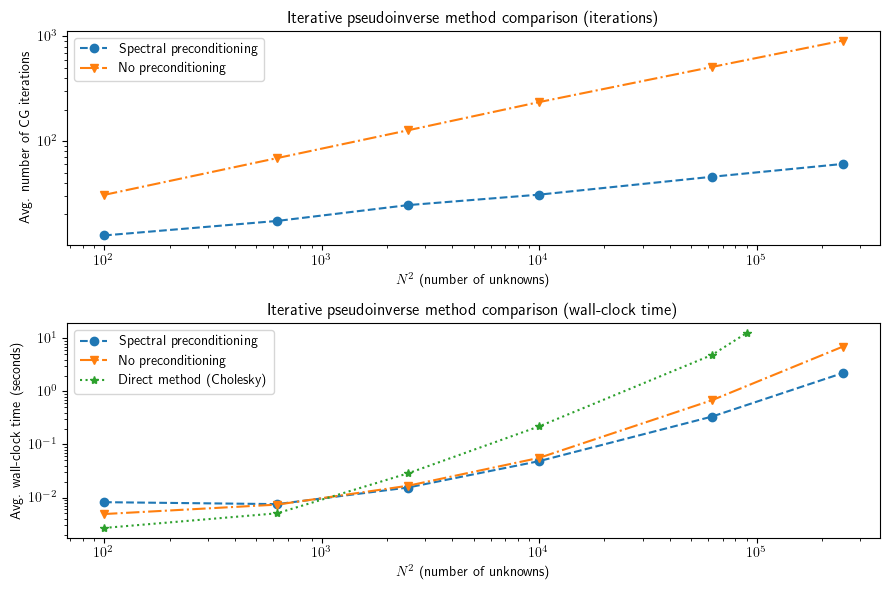

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(9,6))

axs[0].loglog(Ns**2, preconditioned_mean_cg_its, label="Spectral preconditioning", ls="dashed", marker="o")
axs[0].loglog(Ns**2, mean_cg_its, label="No preconditioning", ls="dashdot", marker="v")
axs[0].set_ylabel("Avg. number of CG iterations")
axs[0].set_xlabel("$N^2$ (number of unknowns)")
axs[0].set_title("Iterative pseudoinverse method comparison (iterations)")
axs[0].legend()


axs[1].loglog(Ns**2, preconditioned_time_costs, label="Spectral preconditioning", ls="dashed", marker="o")
axs[1].loglog(Ns**2, time_costs, label="No preconditioning", ls="dashdot", marker="v")
axs[1].loglog(chol_Ns**2, chol_time_costs, label="Direct method (Cholesky)", ls="dotted", marker="*")
axs[1].set_ylabel("Avg. wall-clock time (seconds)")
axs[1].set_xlabel("$N^2$ (number of unknowns)")
axs[1].set_title("Iterative pseudoinverse method comparison (wall-clock time)")
axs[1].legend()


fig.tight_layout()

fig.savefig("lapinv_dirichlet_results.png", dpi=250, bbox_inches="tight")
fig.savefig("lapinv_dirichlet_results.eps", bbox_inches="tight")


plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


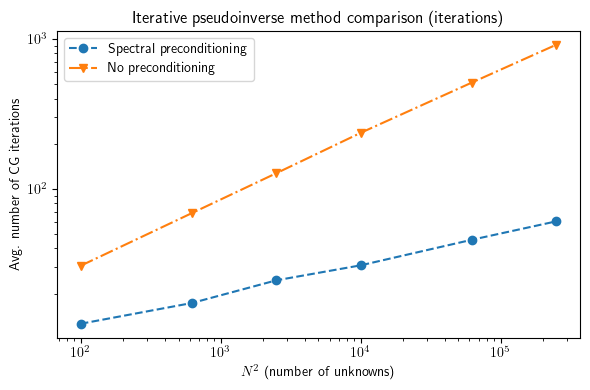

In [ ]:
fig, axs = plt.subplots(1, figsize=(6,4))

axs.loglog(Ns**2, preconditioned_mean_cg_its, label="Spectral preconditioning", ls="dashed", marker="o")
axs.loglog(Ns**2, mean_cg_its, label="No preconditioning", ls="dashdot", marker="v")
axs.set_ylabel("Avg. number of CG iterations")
axs.set_xlabel("$N^2$ (number of unknowns)")
axs.set_title("Iterative pseudoinverse method comparison (iterations)")
axs.legend()


fig.tight_layout()

fig.savefig("lapinv_dirichlet_results_iterations.png", dpi=250, bbox_inches="tight")
fig.savefig("lapinv_dirichlet_results_iterations.eps", bbox_inches="tight")


plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


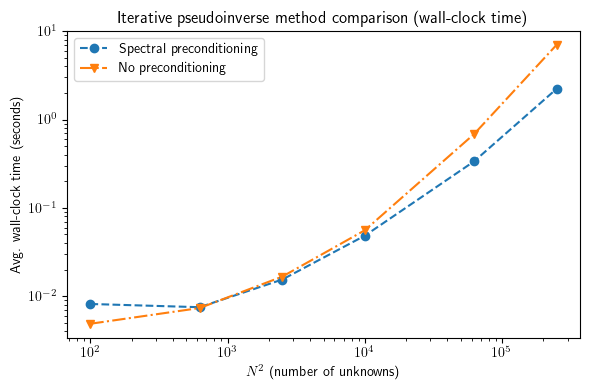

In [ ]:
fig, axs = plt.subplots(1, figsize=(6,4))



axs.loglog(Ns**2, preconditioned_time_costs, label="Spectral preconditioning", ls="dashed", marker="o")
axs.loglog(Ns**2, time_costs, label="No preconditioning", ls="dashdot", marker="v")
#axs.loglog(chol_Ns**2, chol_time_costs, label="Direct method (Cholesky)", ls="dotted", marker="*")
axs.set_ylabel("Avg. wall-clock time (seconds)")
axs.set_xlabel("$N^2$ (number of unknowns)")
axs.set_title("Iterative pseudoinverse method comparison (wall-clock time)")
axs.legend()


fig.tight_layout()

fig.savefig("lapinv_dirichlet_results_wallclock.png", dpi=250, bbox_inches="tight")
fig.savefig("lapinv_dirichlet_results_wallclock.eps", bbox_inches="tight")


plt.show()

# With inverse instead

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


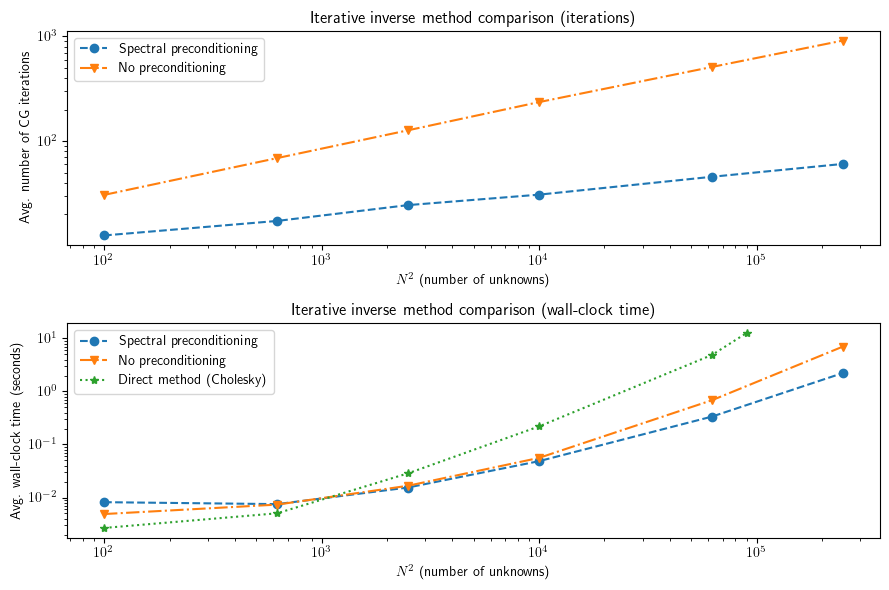

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(9,6))

axs[0].loglog(Ns**2, preconditioned_mean_cg_its, label="Spectral preconditioning", ls="dashed", marker="o")
axs[0].loglog(Ns**2, mean_cg_its, label="No preconditioning", ls="dashdot", marker="v")
axs[0].set_ylabel("Avg. number of CG iterations")
axs[0].set_xlabel("$N^2$ (number of unknowns)")
axs[0].set_title("Iterative inverse method comparison (iterations)")
axs[0].legend()


axs[1].loglog(Ns**2, preconditioned_time_costs, label="Spectral preconditioning", ls="dashed", marker="o")
axs[1].loglog(Ns**2, time_costs, label="No preconditioning", ls="dashdot", marker="v")
axs[1].loglog(chol_Ns**2, chol_time_costs, label="Direct method (Cholesky)", ls="dotted", marker="*")
axs[1].set_ylabel("Avg. wall-clock time (seconds)")
axs[1].set_xlabel("$N^2$ (number of unknowns)")
axs[1].set_title("Iterative inverse method comparison (wall-clock time)")
axs[1].legend()


fig.tight_layout()

fig.savefig("inv_lapinv_dirichlet_results.png", dpi=250, bbox_inches="tight")
fig.savefig("inv_lapinv_dirichlet_results.eps", bbox_inches="tight")


plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


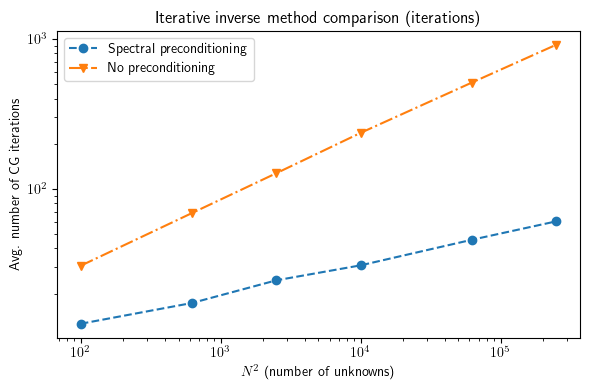

In [ ]:
fig, axs = plt.subplots(1, figsize=(6,4))

axs.loglog(Ns**2, preconditioned_mean_cg_its, label="Spectral preconditioning", ls="dashed", marker="o")
axs.loglog(Ns**2, mean_cg_its, label="No preconditioning", ls="dashdot", marker="v")
axs.set_ylabel("Avg. number of CG iterations")
axs.set_xlabel("$N^2$ (number of unknowns)")
axs.set_title("Iterative inverse method comparison (iterations)")
axs.legend()


fig.tight_layout()

fig.savefig("inv_lapinv_dirichlet_results_iterations.png", dpi=250, bbox_inches="tight")
fig.savefig("inv_lapinv_dirichlet_results_iterations.eps", bbox_inches="tight")


plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


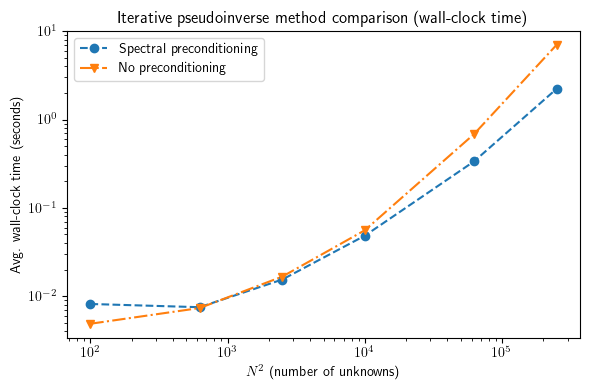

In [ ]:
fig, axs = plt.subplots(1, figsize=(6,4))



axs.loglog(Ns**2, preconditioned_time_costs, label="Spectral preconditioning", ls="dashed", marker="o")
axs.loglog(Ns**2, time_costs, label="No preconditioning", ls="dashdot", marker="v")
#axs.loglog(chol_Ns**2, chol_time_costs, label="Direct method (Cholesky)", ls="dotted", marker="*")
axs.set_ylabel("Avg. wall-clock time (seconds)")
axs.set_xlabel("$N^2$ (number of unknowns)")
axs.set_title("Iterative pseudoinverse method comparison (wall-clock time)")
axs.legend()


fig.tight_layout()

fig.savefig("inv_lapinv_dirichlet_results_wallclock.png", dpi=250, bbox_inches="tight")
fig.savefig("inv_lapinv_dirichlet_results_wallclock.eps", bbox_inches="tight")


plt.show()